# Optimal Clustering 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../')

In [4]:
import random

In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:

from ml4am.optimal_clustering_refactored import ONC, PrunedONC,generate_random_block_correlation_matrix, shuffle_matrix


- A clustering problem consists of a set of objects and a set of features associated with those objects. 
- The goal is to separate the objects into groups (called clusters) using the features, where intragroup similarities are maximized, and intergroup similarities are minimized. 
- It is a form of unsupervised learning, because we do not provide examples to assist the algorithm in solving this task. 
- Clustering problems appear naturally in finance, at every step of the investment process. 
    - For instance, analysts may look for historical analogues to current events, a task that involves developing a numerical taxonomy of events. 
    - Portfolio managers often cluster securities with respect to a variety of features, to derive relative values among peers. 
    - Risk managers are keen to avoid the concentration of risks in securities that share common traits. 
    - Traders wish to understand flows affecting a set of securities, to determine whether a rally or sell-off is idiosyncratic to a particular security, or affects a category shared by a multiplicity of securities. 
    
    

For a given element $i$ and a given clustering, the silhouette $S_i$ is defined as:
$$
S_i = \frac{b_i-a_i}{\max(\{a_i,b_i\}) } , i=1, \cdots, N
$$
where:
- $a_i$ is the average distance between $i$ and all other elements in the same cluster
- $b_i$ is the average distance between $i$ and all the elements in the nearest cluster of which $i$ is not a member. 
- Effectively, this is a measure comparing intracluster distance and intercluster distance.
- A value. $S_i=1$ means that element $i$ is clustered well
- A value $S_i=-1$ means that $i$ was clustered poorly 

For a given partition , the clustering quality $q$ is defined as 

$$ q = \frac{\mathbb{E}(S_i)}{ \sqrt{\mathbb{Var}(S_i)} } $$

where:
- $\mathbb{E}(S_i)$ is the mean of the silhouette coefficients 
- $\mathbb{Var}(S_i)$ is the variance of the silhouette coefficients 

The following modification addresses the k-mean’s initialization problem. \
At the base level, our clustering algorithm performs the following operation: 
- first, evaluate the observation matrix; 
- second, we perform a double for ... loop. 
    - In the first loop, we try different $k=2, \cdots, N$ on which to cluster via $k$-means for one given initialization, and evaluate the quality $q$ for each clustering. 
    - The second loop repeats the first loop multiple times, there by attempting different initializations.
- Third, over these two loops, we select the clustering with the highest $q$.

- The third modification to k-means deals with clusters of inconsistent quality. 
- The base clustering may capture the more distinct clusters, while missing the less apparent (obvious) ones.
- To address this issue, we evaluate the quality $q_k$ of each cluster $k=1, \cdots,K$ given the clustering quality scores obtained from the base clustering algorithm.
- We the take the average quality
$$\overline{q} = \frac{1}{N}\sum_{i=1}^Nq_i $$
- Find the set of clusters with quality below average
$$\{ q_k \mid q_k < \overline{q} , k=1, \cdots, K \}$$
- Let us denote $K_1$ the number of clusters in the previous set, $K_1<K$.
- If the number of clusters to rerun is $K_1 \leq 1$, then we return the clustering given by the base algorithm.
- However, if $K_1 \geq 2$, we rerun the clustering of the items in those $K_1$ clusters, while the rest are considered acceptably clustered. 
- We form a new (reduced) observations matrix out of the elements that compose the $K_1$ clusters, and rerun the base clustering algorithm on that reduced correlation matrix. 
- Doing so will return a, possibly new, clustering for those elements in $K_1$. 
- To check its efficacy, we compare the average cluster quality before and after reclustering those elements in $K_1$. 
- If the average cluster quality improves, we return the accepted clustering from the base clustering concatenated with the new clustering for the redone nodes. 
- Otherwise, we return the clustering formed by the base algorithm.

The Elbow method leverages the within-cluster sum of squares (WCSS). \
The process is pretty straightforward:

- Run k-means clustering   for a range of cluster sizes ($K$ values).
- Compute the total WCSS for each $k = 1, \cdots, K$.
- Create a plot with the number of clusters on the x-axis and the corresponding total WCSS on the y-axis.
- Locate the “elbow” point, where adding another cluster doesn’t offer much better fitting to the data.
- When you increase the number of clusters, the WSS naturally decreases. But after a specific point, you achieve diminishing returns on improving the compactness of the clusters.

Pros:
- Simplicity and Intuitiveness: Easy to understand and implement.
- Good for Quick Decisions: Offers a fast solution without excessive computation. 

Cons:
- Subjectivity: The "elbow" isn’t always clear-cut, leading to different interpretations.
- Oversimplification: May not work as efficiently with complex, high-dimensional data.

- Given the tuple $(N, M, K)$, we wish to create a random block correlation matrix of size $N\times N$, made up of $K$ blocks, each of size greater or equal than $M$. Let us describe the procedure for randomly partitioning $N$ items into $K$ disjoint groups, each of size at least $M$.

- Note that this is equivalent to randomly partitioning $N^{\prime} = N - K(M-1) $ items into $K$ groups each of size at least 1:
    - The adjustment formula $N^{\prime} = N - K(M-1) $ ensures that each box has at least $M$ items at the start, accounting for the $K$ blocks of size $M$ each. 
    - After distributing $M-1$ items to each box, we are left with $N^{\prime}$  items to distribute freely among the $K$ boxes.
    - Randomly partition the $N^{\prime}$ items among the $K$ boxes ensures that each box has at least 1 item (since  $N^{\prime}$  and $K$ are both positive)


- Consider randomly choosing $K - 1$ distinct items, denoted as set $B$, from the set 
$A=(1, \cdots, N^{\prime}-1)$, then add the $(N^{\prime})^{th}$ point to $B$ so that $B$ is of size $K$. 
- Thus, $B$ contains $i_1, \cdots, i_K$, where $1 \leq i_1 < i_2 < \cdots < i_K = N^{\prime}$.
- Given $B$, consider the $K$ partition sets:
    - $C_1=0, \dots, i_{1}-1$
    - $C_2=i_1, \dots, i_{2}-1$
    - $\cdots $
    - $C_K=i_{K-1}, \dots, i_{K}-1$
- Given that $i_j$ are distinct:
    - each partition contains at least one element as desired, 
    - and furthermore completely partitions the set  $(0, \dots, N^{\prime}-1)$
- In doing so, each set $C_j$ contains $i_j - i_{j-1}$ elements for $j=1, \cdots,K$, letting $i_0=0$
- We can generalize again by adding $M-1$ elements to each block.


## Procedure for Creating Random Block Correlation Matrix

Given the tuple $(N, M, K)$, where:
- $N$: Total number of items.
- $M$: Minimum size of each block.
- $K$: Number of blocks.
1. **Adjustment for Minimum Block Size:**
   - Calculate $N' = N - K(M-1)$.
   - This adjustment ensures each block starts with at least $M$ items.
2. **Random Partitioning:**
   - Randomly distribute $N'$ items into $K$ groups, ensuring each group has at least 1 item.
   - This guarantees randomness while meeting the minimum block size requirement.
3. **Specific Procedure:**
   - Randomly choose $K - 1$ distinct items from the set $A = (1, \cdots , N'-1)$.
   - Add the $N'$th item to create set $B$ of size $K$.
   - Set $B$ contains $i_1, \cdots, i_K$, where $1 \leq i_1 < i_2 < \cdots < i_K = N'$.
4. **Partition Sets:**
   - Create $K$ partition sets $C_1, C_2, \cdots, C_K$.
   - Each $C_j$ contains elements from 0 to $N'-1$, with $C_j = i_{j-1}, \cdots, i_{j} - 1$, where $i_0 = 0$.
5. **Generalization for Block Size:**
   - For each block $C_j$, determine the number of extra elements needed to reach size $M$:
     - $\text{extra}_j = \max(0, M - (i_j - i_{j-1}))$
   - Randomly select $\text{extra}_j$ elements from set $A$ and add them to block $C_j$.
   - Repeat this process for all blocks to ensure each has at least M elements.
6. **Generation of covariance matrix $\Sigma$**
   - Let each blokc $k=1, \cdots, K$ have size $x_k \times x_k$, where $x_k \geq M$, thus implying:
       - $x_1+\cdots + x_K = N \geq MK$
   - First, for each block $k$, we create a time series $S$ of length $T$ that is made from iid standard Gaussians, then make copies of that to each column of a matrix $X$ of size $(T, x_k)$.
   - Second, we add to each $X_{ij}$ a random Gaussian with standard deviation $\sigma >0$. By design, the columns of $X$ will be highly correlated for small $\sigma$, and less correlated for large $\sigma$.
   - Third, we evaluate the covariance matrix $\Sigma_X$ for the columns of $X$ , and add $\Sigma_X$ as a block to $\Sigma$
   - Fourth, we add to $\Sigma$ another covariance matrix with one block but larger $\sigma$.
   - Finally, we derive the correlation matrix $\rho$ related to $\Sigma$. By design, $\rho$ will have $K$ blocks with high correlations in side each block, and low correlations otherwise.

We design a Monte Carlo experiment to verify the accuracy of the ONC algorithm introduced earlier:
- first, we create an $N\times N$ correlation matrix $\rho$ from random draws with a predefined number of blocks $K$, where intrablock correlation is high and across-block correlation is low; 
- second, we shuffle that correlation matrix. 
- Third, we apply ONC, and verify that the ONC algorithm recovers the blocks we injected

Let:
- $N$: the number of data points (securities in our case)
- $D$: the number of features characterizing each security
- $X \in \mathbb{R}^{X\times D}$ be the data matrix 
- $X$ follow a multi-variate normal distribution with correlation matrix $\rho$
- $\rho_{ij}$: the correlation between variables $i$ and $j$
- If a strong common component is present, it is advisable to remove it by applying detoning
    - a factor exposure shared by all variables may hide the existence of partly shared exposures
- Since some clustering  algorithms expect as input a measure of similarity (or dissimilarity), we can either use:
    - $\tilde{X}_{ij} = \rho_{ij}$
    - $\tilde{X}_{ij} = \sqrt{\frac{1}{2}(1-\rho_{ij})}$
    

## Generation of Random Block Correlation Matrics 

In [8]:
def covariance2correlation(covariance_matrix: np.ndarray)-> np.ndarray:
    """Converts a covariance matrix into a correlation matrix
    Args:
        covariance_matrix: input covariance matrix
    Returns:
        correlation_matrix: output correlation matrix
    """
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(covariance_matrix))
    correlation_matrix=covariance_matrix/np.outer(std,std)
    correlation_matrix[correlation_matrix<-1] = -1 # numerical error
    correlation_matrix[correlation_matrix>1]  = 1 # numerical error
    return correlation_matrix

def generate_sub_covariance(number_observations: int,
                              number_factors: int,
                              sigma: float,
                              random_state=None) -> np.ndarray:
    """"Generate a sub correlation matrix from highly correlated factors
    Args:
        number_observations: number of observations of underlying factors
        number_factors: number of factors
        sigma: variance of added noise
        random_state: random state

    Returns:
        covariance_matrix: generated covariance matrix
    """
    rng = check_random_state(random_state)
    if number_factors == 1:
        return np.ones((1,1))
    data = rng.normal(size=(number_observations, 1))  
    data = np.repeat(data, number_factors, axis=1)  
    data += rng.normal(loc=0, scale=sigma, size=data.shape)  
    covariance_matrix = np.cov(data, rowvar=False)  
    return covariance_matrix

def generate_random_block_covariance(number_factors: int,
                                     number_blocks: int,
                                     minimum_block_size:int =1,
                                     sigma:float =1.,
                                     random_state=None) -> np.ndarray:
    """ Generate a random block covariance matrix
    Args:
        number_factors: number of factors building the covariance matrix
        number_blocks: number of blocks in the matrix
        minimum_block_size: minimum size of each block
        sigma: variance of the noise in the covariance blocks
        random_state: random state
    Returns:
        covariance_matrix: the generated covariance matrix

    """
    rng = check_random_state(random_state)
    parts = rng.choice(range(1, number_factors - (minimum_block_size - 1) * number_blocks), number_blocks - 1, replace=False)
    parts.sort()
    parts = np.append(parts, number_factors - (minimum_block_size - 1) * number_blocks)  # add nCols to list of parts, unless minBlockSize>1
    parts = np.append(parts[0], np.diff(parts)) - 1 + minimum_block_size
    print("block sizes:" + str(parts))
    covariance_matrix = None
    for number_factors_ in parts:
        # number of observations the underlying factors are generated from
        number_observationsـ = int(max(number_factors_ * (number_factors_ + 1) / 2., 100))
        covariance_ = generate_sub_covariance(number_observationsـ,
                                               number_factors_,
                                               sigma,
                                               random_state=rng)
        if covariance_matrix is None:
            covariance_matrix = covariance_.copy()
        else:
            covariance_matrix = block_diag(covariance_matrix, covariance_)  # list of square matrix on larger matrix on the diagonal

    return covariance_matrix

def generate_random_block_correlation_matrix(number_factors: int,
                                             number_blocks: int ,
                                             minimum_block_size: int=1,
                                             random_state=None
                                             ):
    """Generate a random block correlation matrix
    Args:
        number_factors: number of factors building the covariance matrix
        number_blocks: number of blocks in the matrix
        minimum_block_size: minimum size of each block
        sigma: variance of the noise in the covariance blocks
        random_state: random state
    Returns:
        covariance_matrix: the generated covariance matrix
    """
    rng = check_random_state(random_state)
    # generate signal
    covariance_signal = generate_random_block_covariance(number_factors,
                                            number_blocks,
                                            minimum_block_size=minimum_block_size,
                                            sigma=.5,
                                            random_state=rng)
    # generate noise
    covariance_noise = generate_random_block_covariance(number_factors,
                                            1,
                                            minimum_block_size=minimum_block_size,
                                            sigma=1.,
                                            random_state=rng)
    # add noise
    covariance_signal += covariance_noise
    correlation_matrix = covariance2correlation(covariance_signal)
    correlation_df = pd.DataFrame(correlation_matrix)
    return correlation_df




In [9]:
import numpy as np
import pandas as pd
from sklearn.utils import check_random_state
from scipy.linalg import block_diag
from typing import Optional


class BlockMatrixGenerator:
    """
    A class used to generate covariance and correlation matrices.

    Attributes
    ----------
    number_factors : int
        Number of factors building the covariance matrix.
    number_blocks : int
        Number of blocks in the matrix.
    minimum_block_size : int, optional
        Minimum size of each block (default is 1).
    sigma_signal : float, optional
        Variance of the noise in the signal covariance blocks (default is 1.0).
    sigma_noise : float, optional
        Variance of the noise in the noise covariance blocks (default is 1.0).
    random_state : Optional[int], optional
        Random state for reproducibility (default is None).

    Methods
    -------
    _scale_matrix(matrix: np.ndarray) -> np.ndarray:
        Converts a covariance matrix into a correlation matrix.
    generate_sub_covariance(number_observations: int, number_factors: int, sigma: float, random_state: Optional[int] = None) -> np.ndarray:
        Generates a sub-covariance matrix from highly correlated factors.
    generate_random_block_covariance(number_factors: int, number_blocks: int, minimum_block_size: int = 1, sigma: float = 1.0, random_state: Optional[int] = None) -> np.ndarray:
        Generates a random block covariance matrix.
    generate() -> pd.DataFrame:
        Generates a random block correlation matrix.
    """

    def __init__(self,
                 number_factors: int,
                 number_blocks: int,
                 minimum_block_size: int = 1,
                 sigma_signal: float = 1.0,
                 sigma_noise: float = 1.0,
                 random_state: Optional[int] = None):
        """
        Initializes the BlockMatrixGenerator with the specified parameters.

        Parameters
        ----------
        number_factors : int
            Number of factors building the covariance matrix.
        number_blocks : int
            Number of blocks in the matrix.
        minimum_block_size : int, optional
            Minimum size of each block (default is 1).
        sigma_signal : float, optional
            Variance of the noise in the signal covariance blocks (default is 1.0).
        sigma_noise : float, optional
            Variance of the noise in the noise covariance blocks (default is 1.0).
        random_state : Optional[int], optional
            Random state for reproducibility (default is None).
        """
        self.number_factors = number_factors
        self.number_blocks = number_blocks
        self.minimum_block_size = minimum_block_size
        self.sigma_signal = sigma_signal
        self.sigma_noise = sigma_noise
        self.random_state = random_state

    def _scale_matrix(self, matrix: np.ndarray) -> np.ndarray:
        """
        Converts a covariance matrix into a correlation matrix.

        Parameters
        ----------
        matrix : np.ndarray
            Input covariance matrix.

        Returns
        -------
        np.ndarray
            Output correlation matrix.
        """
        std = np.sqrt(np.diag(matrix))
        scaled_matrix = matrix / np.outer(std, std)
        scaled_matrix[scaled_matrix < -1] = -1  # numerical error
        scaled_matrix[scaled_matrix > 1] = 1  # numerical error
        return scaled_matrix

    def generate_sub_covariance(self,
                                number_observations: int,
                                number_factors: int,
                                sigma: float,
                                random_state: Optional[int] = None) -> np.ndarray:
        """
        Generates a sub-covariance matrix from highly correlated factors.

        Parameters
        ----------
        number_observations : int
            Number of observations of underlying factors.
        number_factors : int
            Number of factors.
        sigma : float
            Variance of added noise.
        random_state : Optional[int], optional
            Random state for reproducibility (default is None).

        Returns
        -------
        np.ndarray
            Generated covariance matrix.
        """
        rng = check_random_state(random_state)
        if number_factors == 1:
            return np.ones((1, 1))
        data = rng.normal(size=(number_observations, 1))
        data = np.repeat(data, number_factors, axis=1)
        data += rng.normal(loc=0, scale=sigma, size=data.shape)
        covariance_matrix = np.cov(data, rowvar=False)
        return covariance_matrix

    def generate_random_block_covariance(self,
                                         number_factors: int,
                                         number_blocks: int,
                                         minimum_block_size: int = 1,
                                         sigma: float = 1.0,
                                         random_state: Optional[int] = None) -> np.ndarray:
        """
        Generates a random block covariance matrix.

        Parameters
        ----------
        number_factors : int
            Number of factors building the covariance matrix.
        number_blocks : int
            Number of blocks in the matrix.
        minimum_block_size : int, optional
            Minimum size of each block (default is 1).
        sigma : float, optional
            Variance of the noise in the covariance blocks (default is 1.0).
        random_state : Optional[int], optional
            Random state for reproducibility (default is None).

        Returns
        -------
        np.ndarray
            The generated covariance matrix.
        """
        rng = check_random_state(random_state)
        parts = rng.choice(range(1, number_factors - (minimum_block_size - 1) * number_blocks), number_blocks - 1, replace=False)
        parts.sort()
        parts = np.append(parts, number_factors - (minimum_block_size - 1) * number_blocks)
        parts = np.append(parts[0], np.diff(parts)) - 1 + minimum_block_size
        covariance_matrix = None
        for number_factors_ in parts:
            number_observations_ = int(max(number_factors_ * (number_factors_ + 1) / 2, 100))
            covariance_ = self.generate_sub_covariance(number_observations_, number_factors_, sigma, random_state=rng)
            if covariance_matrix is None:
                covariance_matrix = covariance_.copy()
            else:
                covariance_matrix = block_diag(covariance_matrix, covariance_)
        return covariance_matrix

    def generate(self) -> pd.DataFrame:
        """
        Generates a random block correlation matrix.

        Returns
        -------
        pd.DataFrame
            The generated correlation matrix.
        """
        rng = check_random_state(self.random_state)
        covariance_signal = self.generate_random_block_covariance(number_factors=self.number_factors,
                                                                  number_blocks=self.number_blocks,
                                                                  minimum_block_size=self.minimum_block_size,
                                                                  sigma=self.sigma_signal,
                                                                  random_state=rng)
        covariance_noise = self.generate_random_block_covariance(number_factors=self.number_factors,
                                                                 number_blocks=1,
                                                                 minimum_block_size=self.minimum_block_size,
                                                                 sigma=self.sigma_noise,
                                                                 random_state=rng)
        covariance_signal += covariance_noise
        correlation_matrix = self._scale_matrix(covariance_signal)
        return pd.DataFrame(correlation_matrix)




In [10]:
number_factors = 100
number_blocks = 6
minimum_block_size=2
random_state=None 

In [ ]:
# Example usage
generator = BlockMatrixGenerator(number_factors=number_factors, 
                                 number_blocks=number_blocks, 
                                 minimum_block_size=minimum_block_size, 
                                 random_state=random_state,
                                sigma_signal  = 1.0,
                 sigma_noise = 0.5)
correlation_df = generator.generate()
# print(correlation_matrix)



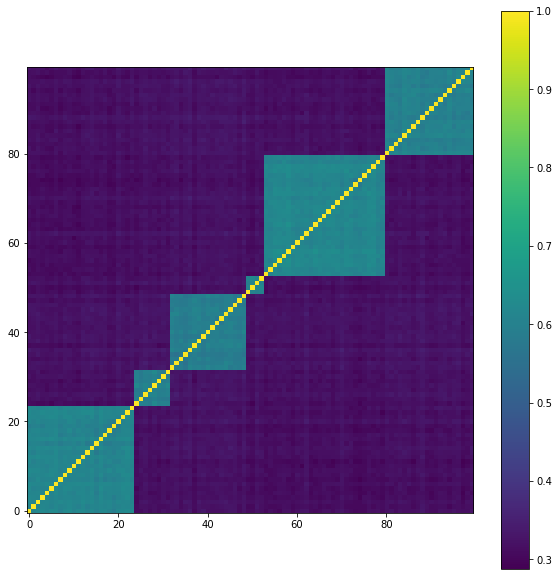

In [25]:
#Draw ground truth
plt.rcParams["figure.figsize"] = (10, 10)
plt.matshow(correlation_df) #invert y-axis to get origo at lower left corner
plt.gca().xaxis.tick_bottom()
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [13]:
correlation_df = generate_random_block_correlation_matrix(number_factors=number_factors,
                                                         number_blocks=number_blocks,
                                                         minimum_block_size=minimum_block_size,
                                                         random_state=random_state)


block sizes:[24  8 17  4 27 20]
block sizes:[100]


In [14]:
correlation_df.shape

(100, 100)

In [15]:
type(correlation_df)

pandas.core.frame.DataFrame

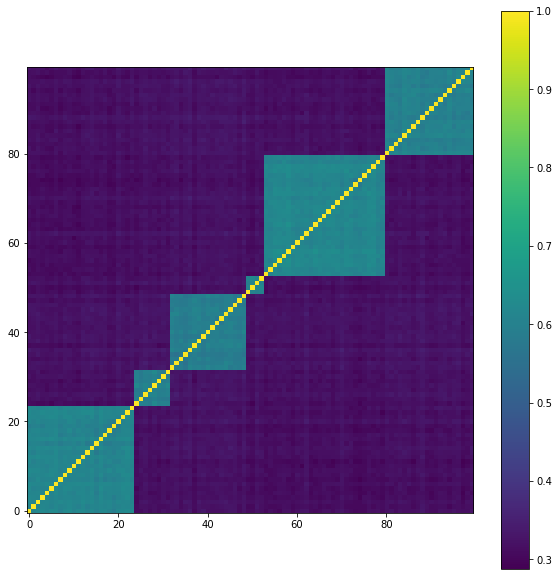

In [16]:
#Draw ground truth
plt.rcParams["figure.figsize"] = (10, 10)
plt.matshow(correlation_df) #invert y-axis to get origo at lower left corner
plt.gca().xaxis.tick_bottom()
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [17]:
shuffled_correlation_df = shuffle_matrix(correlation_df)

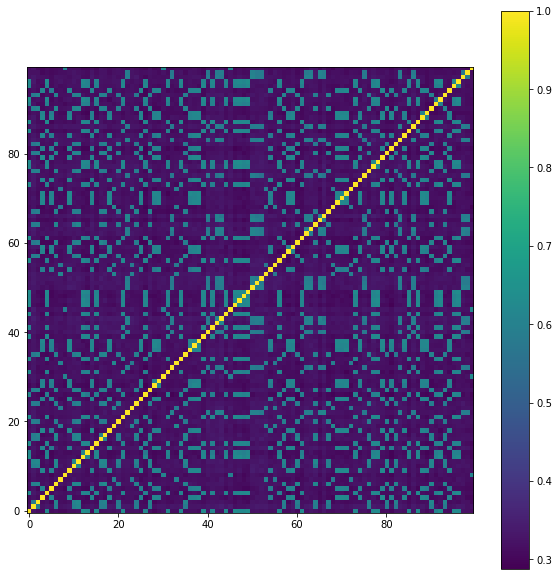

In [18]:
#Draw shuffled matrix 
plt.matshow(shuffled_correlation_df) #invert y-axis to get origo at lower left corner
plt.gca().xaxis.tick_bottom()
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

## ONC algorithm

### Silhouette method

In [19]:
from ml4am.ONC import OptimalClustering

In [20]:
shuffled_correlation_df

,58,88,91,5,61,19,84,27,49,14,...,94,78,56,81,3,54,57,41,47,50
58,1.000000,0.326298,0.312213,0.308821,0.623793,0.307888,0.315609,0.306323,0.306267,0.317410,...,0.322236,0.604681,0.643889,0.314839,0.309877,0.623579,0.629099,0.323894,0.318761,0.310547
88,0.326298,1.000000,0.583952,0.322371,0.332445,0.326195,0.600992,0.323597,0.329314,0.333124,...,0.604051,0.327252,0.318168,0.585012,0.319127,0.326457,0.335319,0.333957,0.318984,0.323758
91,0.312213,0.583952,1.000000,0.310389,0.319512,0.303720,0.615276,0.313288,0.311722,0.320221,...,0.616815,0.305074,0.321711,0.607748,0.309023,0.315247,0.307535,0.323318,0.319697,0.301795
5,0.308821,0.322371,0.310389,1.000000,0.314478,0.610416,0.317497,0.314219,0.313401,0.616257,...,0.307055,0.307373,0.313083,0.304227,0.607632,0.306225,0.312959,0.319093,0.303715,0.299269
61,0.623793,0.332445,0.319512,0.314478,1.000000,0.304537,0.324288,0.320368,0.313193,0.321225,...,0.312812,0.598424,0.619845,0.316811,0.313634,0.610446,0.627286,0.317875,0.312249,0.309112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,0.623579,0.326457,0.315247,0.306225,0.610446,0.308183,0.322373,0.311703,0.315057,0.321972,...,0.317709,0.602941,0.603973,0.314788,0.310095,1.000000,0.623888,0.325910,0.309755,0.317532
57,0.629099,0.335319,0.307535,0.312959,0.627286,0.310018,0.319007,0.328804,0.317487,0.319283,...,0.312989,0.619241,0.635098,0.320237,0.311070,0.623888,1.000000,0.322169,0.314496,0.315612
41,0.323894,0.333957,0.323318,0.319093,0.317875,0.309297,0.326346,0.322066,0.320186,0.315205,...,0.318237,0.319799,0.322667,0.317581,0.316754,0.325910,0.322169,1.000000,0.581338,0.313476
47,0.318761,0.318984,0.319697,0.303715,0.312249,0.304999,0.308478,0.314764,0.314018,0.319385,...,0.313386,0.310916,0.310213,0.311245,0.314128,0.309755,0.314496,0.581338,1.000000,0.309330


In [21]:
onc_model = OptimalClustering(n_jobs=10, max_number_clusters=20)
onc_model.fit( shuffled_correlation_df) 

In [22]:
onc_model.n_clusters

6

In [23]:
onc_correlation_df = onc_model.reordered_X 

In [24]:
#Draw ground truth
plt.rcParams["figure.figsize"] = (10, 10)

plt.matshow(onc_correlation_df) #invert y-axis to get origo at lower left corner
plt.gca().xaxis.tick_bottom()
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()from
    
    

SyntaxError: invalid syntax (2342166659.py, line 8)

### Gap statistic 

In [ ]:
onc_model_gap = OptimalClustering(n_jobs=10, max_number_clusters=20, method='gap_statistic')
onc_model_gap.fit( shuffled_correlation_df) 

In [ ]:
onc_model_gap.n_clusters

In [ ]:
onc_correlation_df = onc_model_gap.reordered_X 

In [ ]:
#Draw ground truth
plt.rcParams["figure.figsize"] = (10, 10)

plt.matshow(onc_correlation_df) #invert y-axis to get origo at lower left corner
plt.gca().xaxis.tick_bottom()
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
    
    

## Pruned ONC algorithm 

In [ ]:
pruned_onc_model = PrunedONC()
pruned_onc_model.fit( shuffled_correlation_df) 

In [ ]:
pruned_onc_model.n_clusters

In [ ]:
pruned_onc_correlation_df = pruned_onc_model.reordered_X 

In [ ]:
#Draw ground truth
plt.rcParams["figure.figsize"] = (10, 10)

plt.matshow(pruned_onc_correlation_df) #invert y-axis to get origo at lower left corner
plt.gca().xaxis.tick_bottom()
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()
    

In [1]:
liar

NameError: name 'liar' is not defined

In [2]:
list

list